In [933]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, make_scorer

# Carregando os dados

In [934]:
df = pd.read_csv("data/desafio_indicium_imdb.csv", index_col=0)

# Informações Iniciais

In [935]:
df

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
4,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"
5,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Breakfast at Tiffany's,1961,A,115 min,"Comedy, Drama, Romance",7.6,A young New York socialite becomes interested ...,76.0,Blake Edwards,Audrey Hepburn,George Peppard,Patricia Neal,Buddy Ebsen,166544,NaN
996,Giant,1956,G,201 min,"Drama, Western",7.6,Sprawling epic covering the life of a Texas ca...,84.0,George Stevens,Elizabeth Taylor,Rock Hudson,James Dean,Carroll Baker,34075,NaN
997,From Here to Eternity,1953,Passed,118 min,"Drama, Romance, War",7.6,"In Hawaii in 1941, a private is cruelly punish...",85.0,Fred Zinnemann,Burt Lancaster,Montgomery Clift,Deborah Kerr,Donna Reed,43374,"30,500,000"
998,Lifeboat,1944,NaN,97 min,"Drama, War",7.6,Several survivors of a torpedoed merchant ship...,78.0,Alfred Hitchcock,Tallulah Bankhead,John Hodiak,Walter Slezak,William Bendix,26471,NaN


Pode-se visualizar que o dataset é ordenado com base em IMDB_rating, de forma descendente.

## Checando os dtypes das colunas

In [936]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 999 entries, 1 to 999
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   999 non-null    object 
 1   Released_Year  999 non-null    object 
 2   Certificate    898 non-null    object 
 3   Runtime        999 non-null    object 
 4   Genre          999 non-null    object 
 5   IMDB_Rating    999 non-null    float64
 6   Overview       999 non-null    object 
 7   Meta_score     842 non-null    float64
 8   Director       999 non-null    object 
 9   Star1          999 non-null    object 
 10  Star2          999 non-null    object 
 11  Star3          999 non-null    object 
 12  Star4          999 non-null    object 
 13  No_of_Votes    999 non-null    int64  
 14  Gross          830 non-null    object 
dtypes: float64(2), int64(1), object(12)
memory usage: 124.9+ KB


É preciso tratar algumas colunas:
- Released_Year: a coluna deveria ser ```int```.
- Runtime: a coluna de duração do filme está em formato ```object``` porque tem o texto ```' mins'``` junto aos minutos.
- Gross: a coluna de renda bruta está em formato ```object``` porque os números possuem vírgulas separando milhões e milhares.

## Checando por dados nulos

In [937]:
nrows_df = df.shape[0]
nrows_df_na = df[df.isna().any(axis=1)].shape[0]

perc_na = 100 * (nrows_df_na)/nrows_df
print(f"{perc_na:.2f}% das linhas têm algum valor faltante em df")

28.63% das linhas têm algum valor faltante em df


In [938]:
df.isnull().sum()

Series_Title       0
Released_Year      0
Certificate      101
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
dtype: int64

As colunas ```Certificate```, ```Meta_score``` e ```Gross``` têm entre 10 a 15% de valores faltantes, o que é uma quantidade considerável. Como visto acima, utilizar o ```dropna()``` removeria quase 30% da base de dados. Vamos avaliar outras alternativas.

## Checando por colunas duplicadas

In [939]:
print(f"{df.duplicated().sum()} linhas duplicadas em df")

0 linhas duplicadas em df


# Tratamento de Dados

## Released_Year

In [940]:
# df['Released_Year'].astype(int, errors='raise')

O código anterior retorna um erro que 'PG' não pode virar integer.

In [941]:
# Checando os valores que a coluna possui
df['Released_Year'].unique()

array(['1972', '2008', '1974', '1957', '2003', '1994', '1993', '2010',
       '1999', '2001', '1966', '2002', '1990', '1980', '1975', '2020',
       '2019', '2014', '1998', '1997', '1995', '1991', '1977', '1962',
       '1954', '1946', '2011', '2006', '2000', '1988', '1985', '1968',
       '1960', '1942', '1936', '1931', '2018', '2017', '2016', '2012',
       '2009', '2007', '1984', '1981', '1979', '1971', '1963', '1964',
       '1950', '1940', '2013', '2005', '2004', '1992', '1987', '1986',
       '1983', '1976', '1973', '1965', '1959', '1958', '1952', '1948',
       '1944', '1941', '1927', '1921', '2015', '1996', '1989', '1978',
       '1961', '1955', '1953', '1925', '1924', '1982', '1967', '1951',
       '1949', '1939', '1937', '1934', '1928', '1926', '1920', '1970',
       '1969', '1956', '1947', '1945', '1930', '1938', '1935', '1933',
       '1932', '1922', '1943', 'PG'], dtype=object)

In [942]:
# Será que houve um erro de leitura? 'PG' é um valor válido para Certificate
df[df['Released_Year']=='PG']

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
966,Apollo 13,PG,U,140 min,"Adventure, Drama, History",7.6,NASA must devise a strategy to return Apollo 1...,77.0,Ron Howard,Tom Hanks,Bill Paxton,Kevin Bacon,Gary Sinise,269197,"173,837,933"


Não foi um erro de leitura, as outras colunas estão corretas. Segundo o IMDB, Apollo 13 foi um filme de 1995.

In [943]:
# Editar o valor de Released_Year de 'Apollo 13'
df.loc[df["Series_Title"] == "Apollo 13", "Released_Year"] = 1995
df[df['Series_Title']=='Apollo 13']

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
966,Apollo 13,1995,U,140 min,"Adventure, Drama, History",7.6,NASA must devise a strategy to return Apollo 1...,77.0,Ron Howard,Tom Hanks,Bill Paxton,Kevin Bacon,Gary Sinise,269197,"173,837,933"


In [944]:
df['Released_Year'] = df['Released_Year'].astype(int)

## Runtime e Gross

In [945]:
# Transformando a coluna 'Runtime' em numérica, removendo o texto ' min'
df['Runtime'] = df['Runtime'].str.replace(" min", "").astype(int)

df['Gross'] = df['Gross'].str.replace(",", "").astype(float) # float pra aceitar os NaN, usar int dá erro

In [946]:
# checando os Dtypes resultantes
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 999 entries, 1 to 999
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   999 non-null    object 
 1   Released_Year  999 non-null    int64  
 2   Certificate    898 non-null    object 
 3   Runtime        999 non-null    int64  
 4   Genre          999 non-null    object 
 5   IMDB_Rating    999 non-null    float64
 6   Overview       999 non-null    object 
 7   Meta_score     842 non-null    float64
 8   Director       999 non-null    object 
 9   Star1          999 non-null    object 
 10  Star2          999 non-null    object 
 11  Star3          999 non-null    object 
 12  Star4          999 non-null    object 
 13  No_of_Votes    999 non-null    int64  
 14  Gross          830 non-null    float64
dtypes: float64(3), int64(3), object(9)
memory usage: 124.9+ KB


## Certificate (Classificação Etária)

A coluna certificate pode ser alterada para a idade mínima permitida para facilitar a leitura.

In [947]:
df['Certificate'].value_counts()

Certificate
U           234
A           196
UA          175
R           146
PG-13        43
PG           37
Passed       34
G            12
Approved     11
TV-PG         3
GP            2
TV-14         1
Unrated       1
TV-MA         1
16            1
U/A           1
Name: count, dtype: int64

In [948]:
certificate_map = {
    "G": "0",
    "U": "0",
    "Passed": "0",
    "Approved": "0",
    "PG": "12",
    "GP": "12",
    "UA": "12",
    "U/A": "12",
    "TV-PG": "12",
    "PG-13": "13",
    "TV-14": "14",
    "16": "16",
    "R": "18",
    "A": "18",
    "TV-MA": "18",
    "NC-17": "18",
    "Unrated": "NR",
    "NR": "NR"
}

# aplicando ao dataframe
df["Certificate"] = df["Certificate"].map(certificate_map)
df = df.rename(columns={"Certificate": "Age_Rating"})

In [949]:
df['Age_Rating'].value_counts().reset_index()

,Age_Rating,count
0,18,343
1,0,291
2,12,218
3,13,43
4,14,1
5,16,1
6,NR,1


In [950]:
print(f"{100*df["Age_Rating"].isna().sum()/df.shape[0]:.2f}% das linhas da coluna 'Age_Rating' são nulas.")

10.11% das linhas da coluna 'Age_Rating' são nulas.


## Drop NA

In [951]:
df.dropna(inplace=True)

In [952]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 713 entries, 1 to 997
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   713 non-null    object 
 1   Released_Year  713 non-null    int64  
 2   Age_Rating     713 non-null    object 
 3   Runtime        713 non-null    int64  
 4   Genre          713 non-null    object 
 5   IMDB_Rating    713 non-null    float64
 6   Overview       713 non-null    object 
 7   Meta_score     713 non-null    float64
 8   Director       713 non-null    object 
 9   Star1          713 non-null    object 
 10  Star2          713 non-null    object 
 11  Star3          713 non-null    object 
 12  Star4          713 non-null    object 
 13  No_of_Votes    713 non-null    int64  
 14  Gross          713 non-null    float64
dtypes: float64(3), int64(3), object(9)
memory usage: 89.1+ KB


# Entendimento dos dados individualmente em cada Coluna

## Released_Year

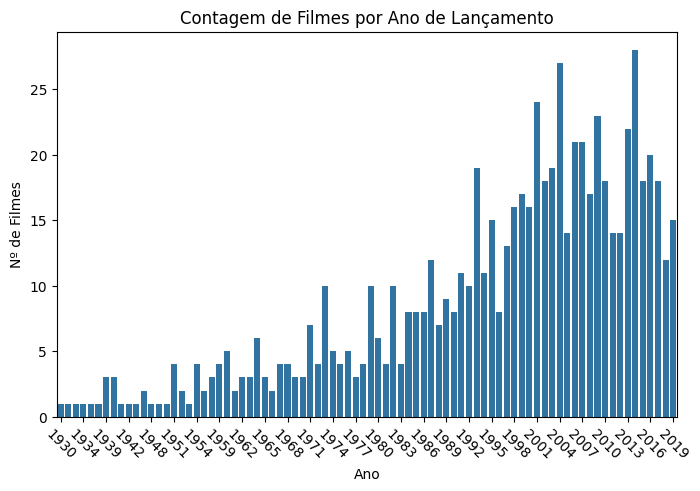

In [953]:
# Contagem de filmes por ano
plt.figure(figsize=(8,5))
year_counts = df['Released_Year'].value_counts().reset_index()
year_counts.columns = ["Released_Year", "count"]
sns.barplot(data=year_counts, x="Released_Year", y="count")

plt.xticks(range(0, len(year_counts), 3), rotation=-45)
plt.title('Contagem de Filmes por Ano de Lançamento')
plt.ylabel('Nº de Filmes')
plt.xlabel('Ano')
plt.show()

## Certificate ~> Age_Rating (Classificação Etária)

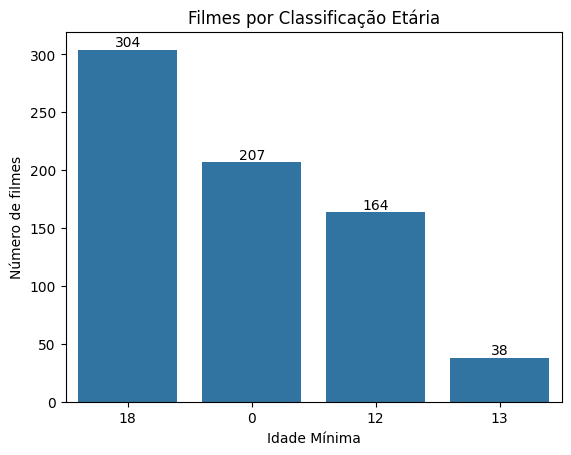

In [954]:
age_rating_counts = df['Age_Rating'].value_counts().reset_index()
age_rating_counts.columns = ["Age_Rating", "count"]

ax = sns.barplot(data=age_rating_counts, x="Age_Rating", y="count")

for container in ax.containers:
    ax.bar_label(container)

plt.ylabel("Número de filmes")
plt.xlabel("Idade Mínima")
plt.title("Filmes por Classificação Etária")
plt.show()

## Runtime (Tempo de Duração)

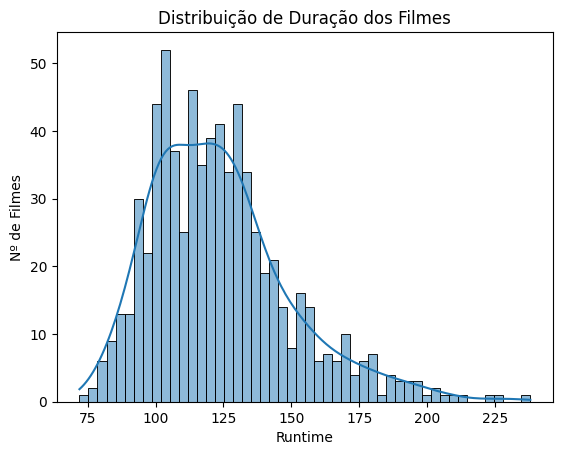

In [955]:
sns.histplot(data=df, x="Runtime", kde=True, bins=50)

plt.title('Distribuição de Duração dos Filmes')
plt.ylabel('Nº de Filmes')
plt.xlabel('Runtime')
plt.show()

In [956]:
df[df['Runtime'] > 220]

,Series_Title,Released_Year,Age_Rating,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
116,Lawrence of Arabia,1962,0,228,"Adventure, Biography, Drama",8.3,"The story of T.E. Lawrence, the English office...",100.0,David Lean,Peter O'Toole,Alec Guinness,Anthony Quinn,Jack Hawkins,268085,44824144.0
247,Lagaan: Once Upon a Time in India,2001,0,224,"Adventure, Drama, Musical",8.1,The people of a small village in Victorian Ind...,84.0,Ashutosh Gowariker,Aamir Khan,Raghuvir Yadav,Gracy Singh,Rachel Shelley,105036,70147.0
314,Gone with the Wind,1939,0,238,"Drama, History, Romance",8.1,A manipulative woman and a roguish man conduct...,97.0,Victor Fleming,George Cukor,Sam Wood,Clark Gable,Vivien Leigh,290074,198676459.0


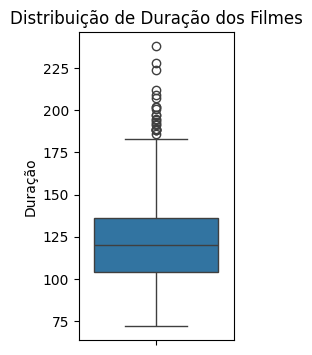

In [957]:
plt.figure(figsize=(2, 4))
sns.boxplot(data=df, y="Runtime")

plt.title('Distribuição de Duração dos Filmes')
plt.ylabel('Duração')
plt.xlabel('')
plt.show()

## Genre (Gênero)

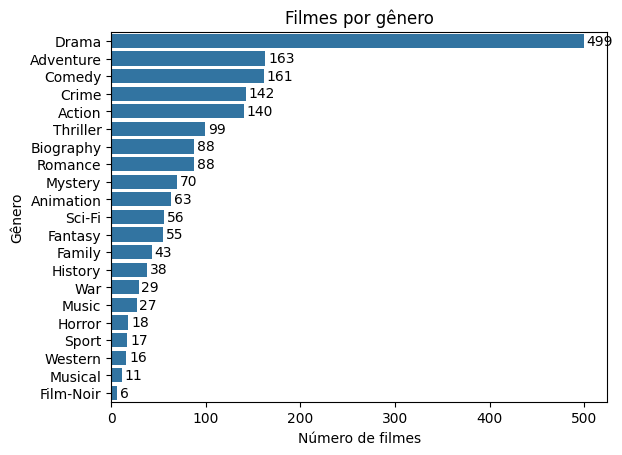

In [958]:
df_exploded = df["Genre"].str.split(",").explode().str.strip()

genre_counts = df_exploded.value_counts().reset_index()

ax = sns.barplot(genre_counts, y=genre_counts['Genre'], x=genre_counts['count'])

# adiciona os valores nas barras
for container in ax.containers:
    ax.bar_label(container, label_type="edge", padding=2)

plt.ylabel("Gênero")
plt.xlabel("Número de filmes")
plt.title("Filmes por gênero")
plt.show()

## IMDB_Rating (Avaliação IMDB)

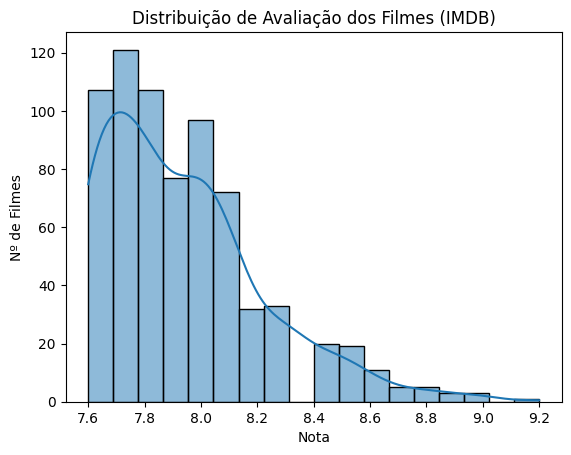

In [959]:
sns.histplot(data=df, x="IMDB_Rating", kde=True)

plt.title('Distribuição de Avaliação dos Filmes (IMDB)')
plt.ylabel('Nº de Filmes')
plt.xlabel('Nota')
plt.show()

In [960]:
df[df['IMDB_Rating'] >= 9.0]

,Series_Title,Released_Year,Age_Rating,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
1,The Godfather,1972,18,175,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0
2,The Dark Knight,2008,12,152,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0
3,The Godfather: Part II,1974,18,202,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0
4,12 Angry Men,1957,0,96,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.0


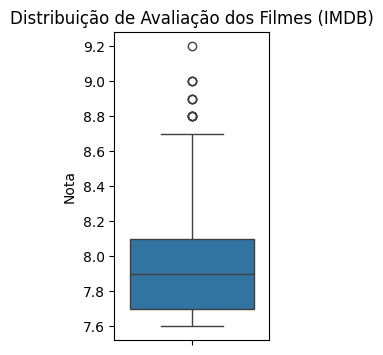

In [961]:
plt.figure(figsize=(2, 4))
sns.boxplot(data=df, y="IMDB_Rating")

plt.title('Distribuição de Avaliação dos Filmes (IMDB)')
plt.ylabel('Nota')
plt.xlabel('')
plt.show()

In [962]:
pattern = r'\s(Part|Chapter|Book)\s(2|II)|(2|II)$'
sequels_df = df[df['Series_Title'].str.contains(pattern, case=False, na=False, regex=True)]

sequels_df

C:\Users\User\AppData\Local\Temp\ipykernel_19540\520565423.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  sequels_df = df[df['Series_Title'].str.contains(pattern, case=False, na=False, regex=True)]


,Series_Title,Released_Year,Age_Rating,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
3,The Godfather: Part II,1974,18,202,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0
226,Harry Potter and the Deathly Hallows: Part 2,2011,12,130,"Adventure, Drama, Fantasy",8.1,"Harry, Ron, and Hermione search for Voldemort'...",85.0,David Yates,Daniel Radcliffe,Emma Watson,Rupert Grint,Michael Gambon,764493,381011219.0
336,Short Term 12,2013,18,96,Drama,8.0,A 20-something supervising staff member of a r...,82.0,Destin Daniel Cretton,Brie Larson,Frantz Turner,John Gallagher Jr.,Kaitlyn Dever,81770,1010414.0
369,Kill Bill: Vol. 2,2004,18,137,"Action, Crime, Thriller",8.0,The Bride continues her quest of vengeance aga...,83.0,Quentin Tarantino,Uma Thurman,David Carradine,Michael Madsen,Daryl Hannah,683900,66208183.0
516,Toy Story 2,1999,0,92,"Animation, Adventure, Comedy",7.9,"When Woody is stolen by a toy collector, Buzz ...",88.0,John Lasseter,Ash Brannon,Lee Unkrich,Tom Hanks,Tim Allen,527512,245852179.0
576,Paddington 2,2017,0,103,"Adventure, Comedy, Family",7.8,"Paddington (Ben Whishaw), now happily settled ...",88.0,Paul King,Ben Whishaw,Hugh Grant,Hugh Bonneville,Sally Hawkins,61594,40442052.0
599,How to Train Your Dragon 2,2014,0,102,"Animation, Action, Adventure",7.8,When Hiccup and Toothless discover an ice cave...,76.0,Dean DeBlois,Jay Baruchel,Cate Blanchett,Gerard Butler,Craig Ferguson,305611,177002924.0
675,Back to the Future Part II,1989,0,108,"Adventure, Comedy, Sci-Fi",7.8,"After visiting 2015, Marty McFly must repeat h...",57.0,Robert Zemeckis,Michael J. Fox,Christopher Lloyd,Lea Thompson,Thomas F. Wilson,481918,118500000.0
678,Evil Dead II,1987,18,84,"Action, Comedy, Fantasy",7.8,The lone survivor of an onslaught of flesh-pos...,72.0,Sam Raimi,Bruce Campbell,Sarah Berry,Dan Hicks,Kassie Wesley DePaiva,148359,5923044.0
722,Deadpool 2,2018,18,119,"Action, Adventure, Comedy",7.7,Foul-mouthed mutant mercenary Wade Wilson (a.k...,66.0,David Leitch,Ryan Reynolds,Josh Brolin,Morena Baccarin,Julian Dennison,478586,324591735.0


## Overview (Descrição curta do filme)

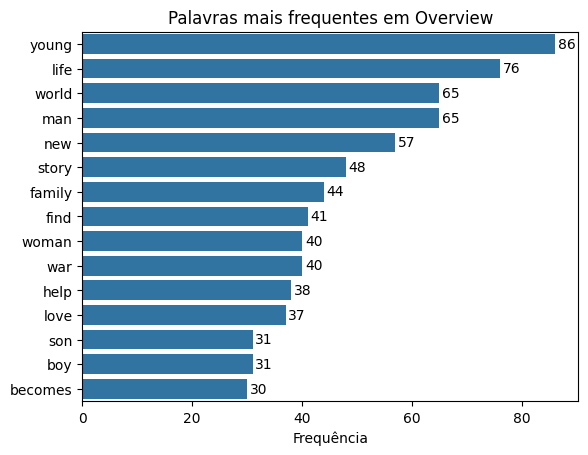

In [963]:
from overview_utils import freq_palavras
from nltk.corpus import stopwords

# 1. Carregue a lista original de stopwords em inglês
stopwords_base = set(stopwords.words('english'))

# 2. Defina as palavras que você quer adicionar
palavras_adicionais = {'must', 'one', 'two'} # Use um set para otimização

# 3. Combine os dois conjuntos
stopwords_custom = stopwords_base.union(palavras_adicionais)

overview_counts = freq_palavras(df['Overview'], stopwords_custom).head(15)

ax = sns.barplot(overview_counts, y=overview_counts['palavra'], x=overview_counts['count'])

# adiciona os valores nas barras
for container in ax.containers:
    ax.bar_label(container, padding=2)

plt.ylabel("")
plt.xlabel("Frequência")
plt.title("Palavras mais frequentes em Overview")
plt.show()

In [964]:
from overview_utils import calcular_media_palavras

media_palavras_por_overview = calcular_media_palavras(df['Overview'], stopwords_custom)

print(f"Cada filme tem em média {media_palavras_por_overview:.0f} palavras (ignorando as stopwords) em sua descrição (Overview).")

Cada filme tem em média 14 palavras (ignorando as stopwords) em sua descrição (Overview).


## Meta_score (Nota do Metacritic)

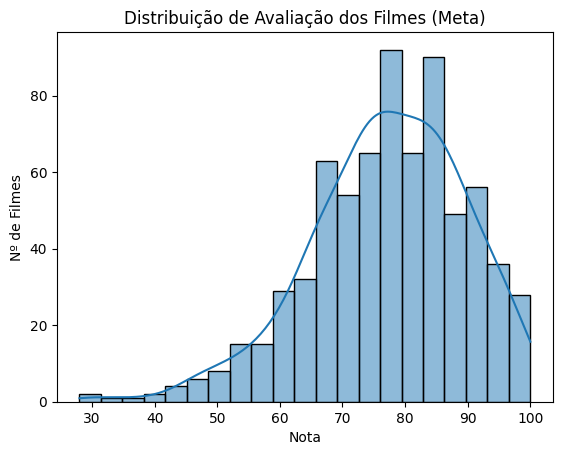

In [965]:
sns.histplot(data=df, x="Meta_score", kde=True)

plt.title('Distribuição de Avaliação dos Filmes (Meta)')
plt.ylabel('Nº de Filmes')
plt.xlabel('Nota')
plt.show()

In [966]:
df[df['Meta_score'] <= 40]

,Series_Title,Released_Year,Age_Rating,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
356,Tropa de Elite,2007,18,115,"Action, Crime, Drama",8.0,"In 1997 Rio de Janeiro, Captain Nascimento has...",33.0,José Padilha,Wagner Moura,André Ramiro,Caio Junqueira,Milhem Cortaz,98097,8060.0
735,Kai po che!,2013,0,130,"Drama, Sport",7.7,Three friends growing up in India at the turn ...,40.0,Abhishek Kapoor,Amit Sadh,Sushant Singh Rajput,Rajkummar Rao,Amrita Puri,32628,1122527.0
788,I Am Sam,2001,13,132,Drama,7.7,A mentally handicapped man fights for custody ...,28.0,Jessie Nelson,Sean Penn,Michelle Pfeiffer,Dakota Fanning,Dianne Wiest,142863,40311852.0
917,Seven Pounds,2008,12,123,Drama,7.6,A man with a fateful secret embarks on an extr...,36.0,Gabriele Muccino,Will Smith,Rosario Dawson,Woody Harrelson,Michael Ealy,286770,69951824.0
942,The Butterfly Effect,2004,0,113,"Drama, Sci-Fi, Thriller",7.6,Evan Treborn suffers blackouts during signific...,30.0,Eric Bress,J. Mackye Gruber,Ashton Kutcher,Amy Smart,Melora Walters,451479,57938693.0


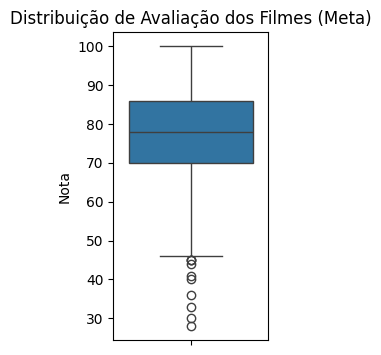

In [967]:
plt.figure(figsize=(2, 4))
sns.boxplot(data=df, y="Meta_score")

plt.title('Distribuição de Avaliação dos Filmes (Meta)')
plt.ylabel('Nota')
plt.xlabel('')
plt.show()

## Director

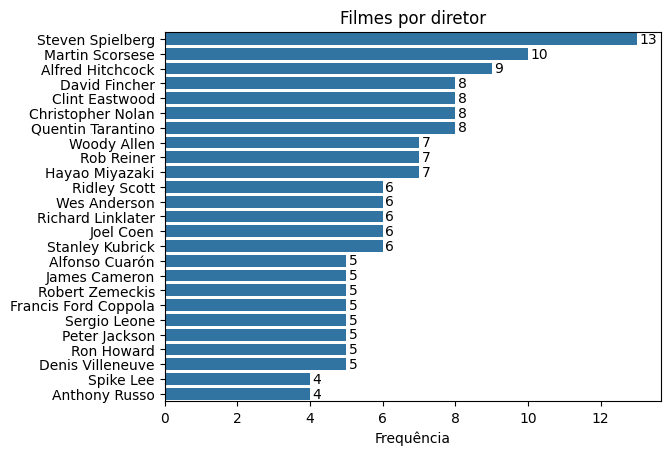

In [968]:
director_counts = df['Director'].value_counts().reset_index().head(25)

ax = sns.barplot(director_counts, y=director_counts['Director'], x=director_counts['count'])

# adiciona os valores nas barras
for container in ax.containers:
    ax.bar_label(container, padding=2)

plt.ylabel("")
plt.xlabel("Frequência")
plt.title("Filmes por diretor")
plt.show()

## Star1, Star2, Star3, Star4 (Atores)

 Número de atores existentes na database: 1912


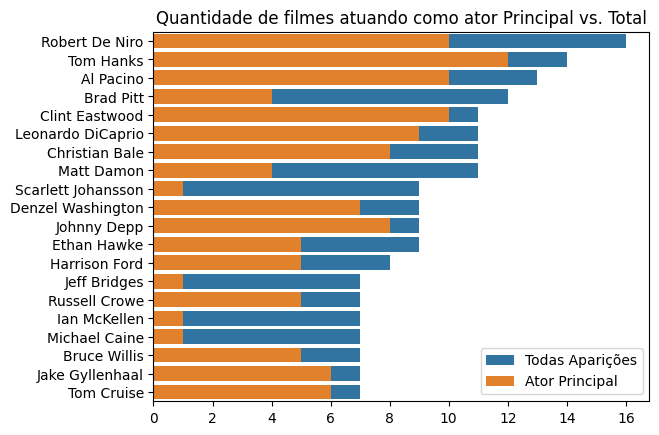

In [969]:
# Calculando o número de vezes que cada ator aparece como Star1, ou ator principal
main_character_counts = df['Star1'].value_counts().reset_index().rename(columns={'Star1': 'Actor'})
main_character_counts_top = ((df['Star1'].value_counts().reset_index()).copy()).head(25)

# Calculando quantos filmes cada ator aparece nas posições 1 a 4
casting = df.melt(
    id_vars=["Series_Title"], 
    value_vars=["Star1", "Star2", "Star3", "Star4"],
    value_name="Actor"
)["Actor"]

total_casting_counts = casting.value_counts().reset_index()

# Printando número de atores únicos
print(f" Número de atores existentes na database: {casting.nunique()}")

# Fazendo merge nas duas contagens: ator principal ou ator 1 a 4
actors_count = pd.merge(main_character_counts, total_casting_counts, on='Actor', suffixes=['_main', '_total'])
actors_count_top = actors_count.sort_values(ascending=False, by='count_total').head(20) # pegando os primeiros ao ordenar por número de filmes totais, facilitando visibilidade do gráfico

# Plot do gráfico
bar1 = sns.barplot(y='Actor',  x='count_total', data=actors_count_top[['Actor', 'count_total']], label='Todas Aparições')
bar2 = sns.barplot(y='Actor', x='count_main', data=actors_count_top[['Actor', 'count_main']], label='Ator Principal')

plt.legend()
plt.title("Quantidade de filmes atuando como ator Principal vs. Total")
plt.xlabel("")
plt.ylabel("")
plt.show()

# ------------- Observações: ----------------------------------
# Tecnicamente, um ator pode ter aparecido em filmes que estão na database, mas a partir da posição 4. O que faz com que eles não apareçam.
# Star2 a 4 não significa que o ator não é um ator principal, pois os filmes podem ter mais de um ator principal

# Analisar este gráfico com estas observações em mente


## No_of_Votes (Número)

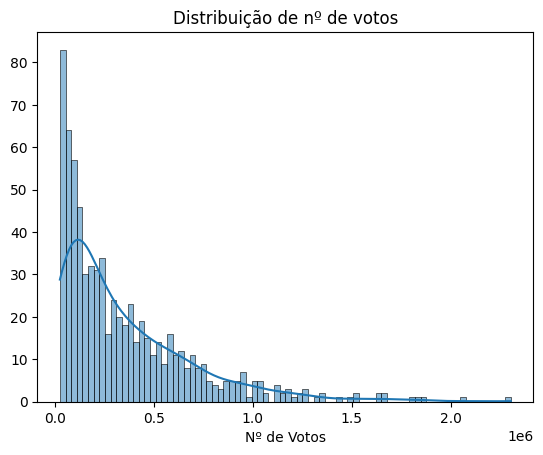

In [970]:
sns.histplot(data=df, x="No_of_Votes", kde=True, bins=80)

plt.title('Distribuição de nº de votos')
plt.ylabel('')
plt.xlabel('Nº de Votos')
plt.show()

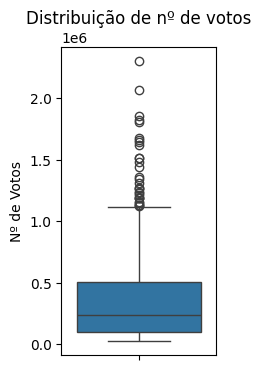

In [971]:
plt.figure(figsize=(2, 4))
sns.boxplot(data=df, y="No_of_Votes")

plt.title('Distribuição de nº de votos')
plt.ylabel('Nº de Votos')
plt.xlabel('')
plt.show()

## Gross (Renda Bruta)

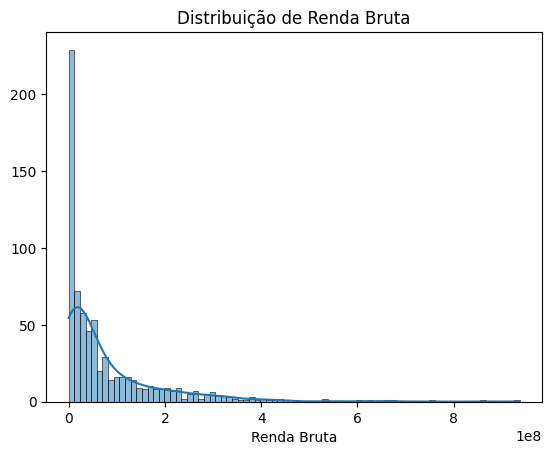

In [972]:
sns.histplot(data=df, x="Gross", kde=True, bins=80)

plt.title('Distribuição de Renda Bruta')
plt.ylabel('')
plt.xlabel('Renda Bruta')
plt.show()

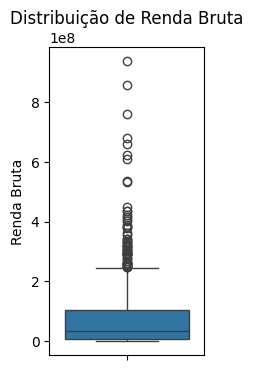

In [973]:
plt.figure(figsize=(2, 4))
sns.boxplot(data=df, y="Gross")

plt.title('Distribuição de Renda Bruta')
plt.ylabel('Renda Bruta')
plt.xlabel('')
plt.show()

```Gross``` tem uma grande quantidade de outliers.

### Remoção de Outliers em Gross

In [974]:
# 1. Calcular o primeiro quartil (Q1) e o terceiro quartil (Q3)
Q1 = df['Gross'].quantile(0.25)
Q3 = df['Gross'].quantile(0.75)

# 2. Calcular o Intervalo Interquartil (IQR)
IQR = Q3 - Q1

# 3. Definir os limites inferior e superior para a detecção de outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 4. Filtrar o DataFrame para manter apenas os valores que estão dentro dos limites
df = df[(df['Gross'] >= lower_bound) & (df['Gross'] <= upper_bound)]

In [975]:
df.shape

(653, 15)

# Interações entre Colunas (WIP)

# Importância das Colunas

In [976]:
## [Enconding] Genre e Actors

# Combinar Genre e Actors em listas
df['Genre_list'] = df['Genre'].apply(lambda x: [g.strip() for g in x.split(',')])
df['Actors_list'] = df[['Star1', 'Star2', 'Star3', 'Star4']].values.tolist()

# Multilabel
mlb_genre = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(mlb_genre.fit_transform(df['Genre_list']), columns=mlb_genre.classes_, index=df.index)

mlb_actors = MultiLabelBinarizer()
actors_encoded = pd.DataFrame(mlb_actors.fit_transform(df['Actors_list']), columns=mlb_actors.classes_, index=df.index)

X_numeric = df[['Runtime', 'Meta_score', 'No_of_Votes', 'IMDB_Rating']]
y = df['Gross']

# Concatenar tudo
X = pd.concat([X_numeric, genre_encoded, actors_encoded], axis=1)

In [ ]:
import statsmodels.api as sm

# Filtrar atores que aparecem em pelo menos 3 filmes
actor_counts = pd.Series([a for sublist in df['Actors_list'] for a in sublist]).value_counts()
frequent_actors = actor_counts[actor_counts >= 5].index.tolist()

# Mantém apenas os atores frequentes
df['Actors_list_filtered'] = df['Actors_list'].apply(lambda x: [a for a in x if a in frequent_actors])

# Recria codificação binária
mlb_actors = MultiLabelBinarizer()
actors_encoded = pd.DataFrame(
    mlb_actors.fit_transform(df['Actors_list_filtered']),
    columns=mlb_actors.classes_,
    index=df.index
)

X_numeric = df[['Runtime', 'Meta_score', 'No_of_Votes', 'IMDB_Rating']]

# ====== 3. Montando dataset ======
features = pd.concat([X_numeric, genre_encoded, actors_encoded], axis=1)

X = sm.add_constant(features)
y = df['Gross']

print("===== Avaliando se Alguma Variável Dummy Tem Multicolinearidade =====")
corr = X.corr()
high_corr = corr[(corr > 0.9) & (corr < 1.0)]
print(high_corr.dropna(how='all', axis=0).dropna(how='all', axis=1))

# ====== 4. Regressão OLS ======
model = sm.OLS(y, X).fit()

# ====== 5. Ranking de variáveis ======
# Extrai coeficientes, p-values e ordena por efeito absoluto
results_df = pd.DataFrame({
    "feature": model.params.index,
    "coef": model.params.values,
    "p_value": model.pvalues.values
})

# Remove intercepto
results_df = results_df[results_df["feature"] != "const"]

# Ordena por valor absoluto do coeficiente
results_df["abs_coef"] = results_df["coef"].abs()
results_df = results_df.sort_values("abs_coef", ascending=False)

# Filtra apenas variáveis significativas (p < 0.05)
significant = results_df[results_df["p_value"] < 0.05]

print("===== Ranking de Variáveis Significativas =====")
print(significant)

Empty DataFrame
Columns: []
Index: []
===== Ranking de Variáveis Significativas =====
               feature          coef       p_value      abs_coef
4          IMDB_Rating -8.872972e+07  5.091332e-21  8.872972e+07
56          Matt Damon  6.184602e+07  1.029465e-05  6.184602e+07
36      Dustin Hoffman  5.868943e+07  1.298858e-03  5.868943e+07
60         Paul Newman  5.611839e+07  2.055136e-03  5.611839e+07
68           Tom Hanks  5.439367e+07  1.170767e-04  5.439367e+07
38       Edward Norton -5.072164e+07  3.088669e-03  5.072164e+07
65  Scarlett Johansson -4.414064e+07  1.888549e-02  4.414064e+07
7            Animation  2.842367e+07  3.710701e-04  2.842367e+07
12              Family  2.129094e+07  1.512286e-02  2.129094e+07
10               Crime -1.433095e+07  5.670702e-03  1.433095e+07
6            Adventure  1.338157e+07  1.821389e-02  1.338157e+07
5               Action  1.305670e+07  2.465828e-02  1.305670e+07
1              Runtime  3.696932e+05  2.906403e-05  3.696932e+05
3   

In [728]:
rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 2, 3, 4, 5, 6, 7, 8],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6]
}

scoring = {
    'MAE': 'neg_mean_absolute_error',
    'RMSE': 'neg_root_mean_squared_error',
    'R2': 'r2'
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='R2',
    return_train_score=True,
    n_jobs=-1
)

grid_search.fit(X, y)

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X)

mae = mean_absolute_error(y, y_pred)
rmse = root_mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print("Melhores parâmetros:", grid_search.best_params_)
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

# Importâncias
importances = best_rf.feature_importances_

Melhores parâmetros: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
MAE: 26558203.52
RMSE: 35948216.06
R²: 0.64


In [729]:
def plot_feature_importances_exploded(importances):
    # Colunas correspondentes
    columns = X.columns

    # Criar DataFrame para visualização
    feature_importance_df = pd.DataFrame({
        'Feature': columns,
        'Importance': importances
    })

    # Ordenar do mais importante para o menos importante
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    import matplotlib.pyplot as plt

    plt.figure(figsize=(10,6))
    plt.barh(feature_importance_df['Feature'][:20][::-1], feature_importance_df['Importance'][:20][::-1])
    plt.xlabel("Importância")
    plt.title("Top 20 Features mais importantes")
    plt.show()

def plot_feature_importances_grouped(importances):
    # Agrupar importâncias por tipo de feature
    numeric_cols = ['Runtime', 'Meta_score', 'No_of_Votes', 'IMDB_Rating']
    genre_cols = genre_encoded.columns
    actor_cols = actors_encoded.columns

    # Importâncias individuais
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    })

    # Importância agregada
    importance_genre = feature_importance_df[feature_importance_df['Feature'].isin(genre_cols)]['Importance'].sum()
    importance_actor = feature_importance_df[feature_importance_df['Feature'].isin(actor_cols)]['Importance'].sum()

    # Criar DataFrame final
    final_df = feature_importance_df[feature_importance_df['Feature'].isin(numeric_cols)].copy()
    final_df = pd.concat([
        final_df,
        pd.DataFrame({
            'Feature': ['Genre', 'Actor'],
            'Importance': [importance_genre, importance_actor]
        })
    ], ignore_index=True)

    # Ordenar por importância
    final_df = final_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

    import matplotlib.pyplot as plt

    plt.figure(figsize=(6,4))
    sns.barplot(data=final_df, x='Importance', y='Feature')
    plt.ylabel('Importância total')
    plt.title('Importância agregada por grupo de features')
    plt.show()

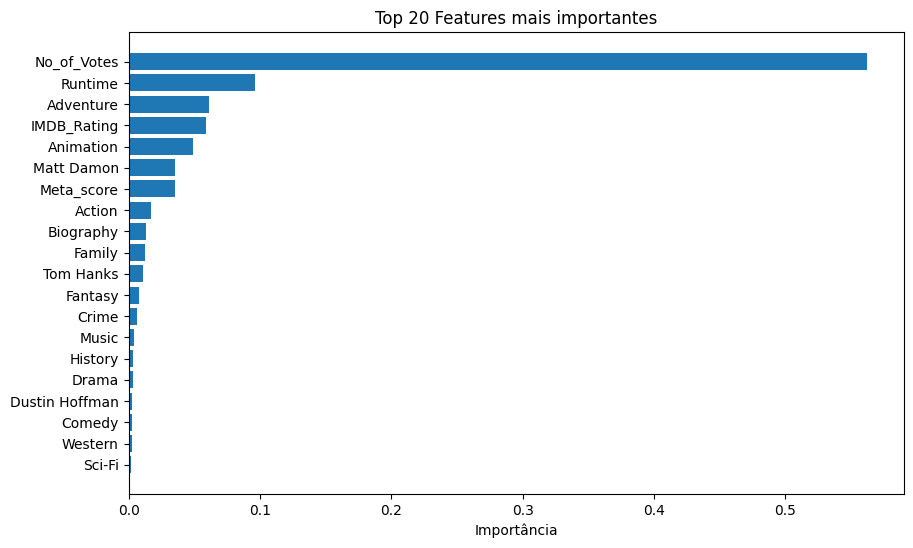

In [730]:
plot_feature_importances_exploded(importances)

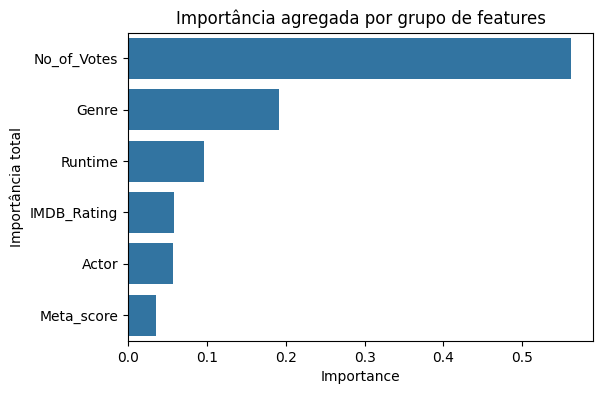

In [731]:
plot_feature_importances_grouped(importances)